In [1]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

from common import dataset_loaders
import settings
import numpy as np
import pandas as pd
from skimage.feature import blob_dog, blob_log, blob_doh
import time



t1 = time.time()

# Prepare model parametrization


## Set the same metaparameters we used for the first stage prediction
annotation_basename = 'sfinder'
model_name = 'patch_seal_finder'
annotations_path = "%s/%s/annotations" % (settings.DATAMODEL_PATH, model_name)
scan_window = 20
window_size = 80


## Functions

In [9]:
from pylab import *
import numpy as np
import scipy.ndimage.filters as fi
%matplotlib inline


def load_predictions(casename, df, class_to_index, scan_window, window_size):
    NUM_CLASSES = len(list(class_to_index.keys()))
    def reconstruct_original(img, preds):
        rec_im = np.zeros(img.shape[:2])
        for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
            for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
                value = preds[int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)][0]
                rec_im[i-int(window_size/2):i+int(window_size/2),j-int(window_size/2):j+int(window_size/2)] += value
        return rec_im

    def get_label_density(img, label):

        def gkern2(inp, nsig=20):
            """Returns a 2D Gaussian kernel array normalized to the maximum of the response"""
            imp_resp = np.zeros([100,100]); imp_resp[50,50] = 1 ; z = fi.gaussian_filter(imp_resp, nsig) # maximum of the impulse response
            norm_value = z.max() * 0.95 # We soft the function so the 1s area is a bit bigger
            ret = fi.gaussian_filter(inp, nsig) / norm_value 
            return np.clip(ret, 0., 1) # each normal will peak at 1... but we can add them and have values higher than 1! We simply clip it

        rec_im = np.zeros([img.shape[0], img.shape[1], NUM_CLASSES])
        for i in labels.index.values:
            row = labels.ix[i]
            rec_im[row.x,row.y,class_to_index[row['class']]] = 1
        for i_class in range(NUM_CLASSES):
            rec_im[:,:,i_class] = gkern2(rec_im[:,:,i_class])
        return np.nan_to_num(rec_im)

    img = dataset_loaders.load_image(casename)
    pred = np.load("%s/%s_%s_%d.npz" % (annotations_path, annotation_basename, casename, scan_window))
    if int(casename) in df['image'].unique():
        labels = df[df['image'] == int(casename)]
        lab_dens = get_label_density(img, labels)
    else:
        labels = None
    return img, reconstruct_original(img, pred['preds']), lab_dens


## Visualization

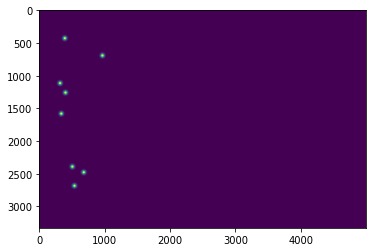

In [95]:

## VISUALIZATION
'''
def volume_to_analyze(rec_im, thrs):
    new_imgs = (rec_im>7).sum()
    a, b = img.shape[:2]
    original_imgs = a * b
    return new_imgs, original_imgs, new_imgs/original_imgs

thrs = 7
img, rec_im, lab_dens = load_predictions('616', original_labels)

# Image section
show_wind = 250
x0,x1,y0,y1 = int(labels.x.median())-show_wind, int(labels.x.median())+show_wind, int(labels.y.median())-show_wind, int(labels.y.median())+show_wind
figure(figsize=(10,10))
subplot(121)
imshow(img[x0:x1,y0:y1,:])
subplot(122)
imshow(img[x0:x1,y0:y1,:])
imshow(rec_im[x0:x1,y0:y1]*(rec_im[x0:x1,y0:y1]>thrs), cmap = cm.Reds, alpha = 0.4)

# Labels section
figure(figsize=(10,10))
colors = [cm.Reds, cm.Greens, cm.Blues, cm.Greys, cm.Oranges]
for i_class in range(NUM_CLASSES):
    subplot(231+i_class)
    imshow(img[x0:x1,y0:y1,:])
    imshow(lab_dens[x0:x1,y0:y1,i_class], cmap = colors[i_class], alpha = 0.4)

# Image section
figure(figsize=(10,10))
subplot(121)
imshow(img)
subplot(122)
imshow(img)
imshow(rec_im*(rec_im>thrs), cmap = cm.Reds, alpha = 0.4)

# Proportion of the image stil to be analized
volume_to_analyze(rec_im, thrs)
'''
#img, rec_im, lab_dens = load_predictions('616', original_labels)
#imshow(lab_dens[:,:,0])
#x, y = lab_dens[:,:,2].max(axis=1).argmax(), lab_dens[:,:,2].max(axis=0).argmax()
#imshow(lab_dens[x-250:x+500,y-250:y+500,2] > 1)

In [13]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

import time
from common import dataset_loaders
import settings
import numpy as np
import pandas as pd

## Set the same metaparameters we used for the first stage prediction
annotation_basename, model_name = 'sfinder', 'patch_seal_finder'
annotation_scan_window, annotation_window_size = 20, 80
MAX_SAMPLES_PER_IMAGE = 1000000 # Samples we are going to generate per image
thrs = 7
class_to_index = {0:0,1:1,2:2,3:3,4:4}


## Load the labels the same way we loaded them to run the first stage prediction
original_labels = dataset_loaders.groundlabels_dataframe()
annotations_path = "%s/%s/annotations" % (settings.DATAMODEL_PATH, model_name)


def generate_candidates(N_samples, candidate_space):
    candidates = []
    for xcan,ycan in zip(np.random.randint(candidate_space.shape[0], size=N_samples),
                         np.random.randint(candidate_space.shape[1], size=N_samples)):
        if candidate_space[xcan,ycan]:
            candidates.append([xcan, ycan])
    return candidates

t1 = time.time()
img, rec_im, lab_dens = load_predictions('616', original_labels, class_to_index, annotation_scan_window, annotation_window_size)
candidate_space = rec_im>thrs
t2 = time.time()
samples = generate_candidates(MAX_SAMPLES_PER_IMAGE, candidate_space)
print(time.time()-t1, time.time()-t2, len(samples), MAX_SAMPLES_PER_IMAGE)

19.122917652130127 0.37668800354003906 25908 1000000


In [14]:
def samples_from_coordinates(img, lab_dens, coordinates, batch_size = 20, wind_shapes = [80, 60, 100]):
    X = [np.zeros([batch_size, 3,wind_, wind_]) for wind_ in wind_shapes] # A different array for each input
    Y = np.zeros([batch_size, lab_dens.shape[2]])
    max_wind = np.max(wind_shapes)
    current_index = 0
    for i_coord in range(len(coordinates)):
        i, j = coordinates[i_coord][0], coordinates[i_coord][1]
        if      i-int(max_wind/2) >= 0 and \
                j-int(max_wind/2) >= 0 and \
                i+int(max_wind/2) < img.shape[0] and \
                j+int(max_wind/2) < img.shape[1]:
            Y[current_index] = lab_dens[i,j]
            for iwind, wind_ in enumerate(wind_shapes):
                X[iwind][current_index] = img[i-int(wind_/2):i+int(wind_/2),j-int(wind_/2):j+int(wind_/2),:].transpose(2,0,1)
            current_index += 1
        if current_index == batch_size:
            yield X, Y
            current_index = 0
    if current_index != 0:
        yield [X[iwind][:current_index] for iwind in range(len(wind_shapes))], Y[:current_index]

t0 = time.time()
samples_gen = samples_from_coordinates(img, lab_dens, samples, batch_size = 20, wind_shapes = [40,60,80,100])
for x, y in samples_gen:
    print(time.time()-t0)

'''
for i_sample in range(10):
    figure()
    subplot(141)
    imshow(x[0][i_sample].transpose([1,2,0]))
    subplot(142)
    imshow(x[1][i_sample].transpose([1,2,0]))
    subplot(143)
    imshow(x[2][i_sample].transpose([1,2,0]))
    subplot(144)
    imshow(x[3][i_sample].transpose([1,2,0]))
    title(str(y[i_sample]))
'''

0.005402088165283203
0.009077072143554688
0.012971639633178711
0.016109704971313477
0.019644975662231445
0.022957324981689453
0.02595353126525879
0.029585838317871094
0.03274035453796387
0.036257028579711914
0.03928184509277344
0.0422976016998291
0.04553794860839844
0.04860711097717285
0.0518343448638916
0.05495786666870117
0.058007001876831055
0.061222076416015625
0.06433796882629395
0.0673685073852539
0.07036423683166504
0.07366657257080078
0.07672834396362305
0.07992434501647949
0.08286333084106445
0.08587908744812012
0.08908390998840332
0.09213137626647949
0.09533977508544922
0.09855508804321289
0.10161423683166504
0.10471749305725098
0.10786080360412598
0.1109771728515625
0.11409902572631836
0.11729240417480469
0.12037849426269531
0.12355470657348633
0.12657546997070312
0.12983965873718262
0.1329183578491211
0.1359720230102539
0.13906097412109375
0.14209675788879395
0.14540481567382812
0.1484665870666504
0.15148687362670898
0.154585599899292
0.15771198272705078
0.1608412265777588


1.4259681701660156
1.4298319816589355
1.4332306385040283
1.4362761974334717
1.4395439624786377
1.4427216053009033
1.4459826946258545
1.4494004249572754
1.45279860496521
1.4559476375579834
1.459592580795288
1.4627881050109863
1.4659833908081055
1.4690372943878174
1.4725916385650635
1.475670576095581
1.4787609577178955
1.4819250106811523
1.4849662780761719
1.4881272315979004
1.4912123680114746
1.49428391456604
1.4972686767578125
1.5003883838653564
1.5035181045532227
1.5066795349121094
1.5096721649169922
1.5128204822540283
1.515977144241333
1.5190515518188477
1.5221493244171143
1.525562047958374
1.5290355682373047
1.532191514968872
1.5352277755737305
1.5384018421173096
1.541482925415039
1.5445988178253174
1.5476717948913574
1.550861120223999
1.5543580055236816
1.5576651096343994
1.560821771621704
1.5638587474822998
1.5670852661132812
1.57027268409729
1.573498249053955
1.5765752792358398
1.5796635150909424
1.5833454132080078
1.586855173110962
1.5910439491271973
1.594409465789795
1.59766340

3.002474308013916
3.0068438053131104
3.0100629329681396
3.0132641792297363
3.0167741775512695
3.020254373550415
3.0241379737854004
3.0274558067321777
3.030503988265991
3.0336735248565674
3.036956548690796
3.040299415588379
3.0438930988311768
3.047943353652954
3.051482915878296
3.0545401573181152
3.057835578918457
3.061262369155884
3.0646307468414307
3.0677356719970703
3.070765972137451
3.074127435684204
3.0775792598724365
3.080620288848877
3.0838141441345215
3.0871241092681885
3.090280771255493
3.0933661460876465
3.0964035987854004
3.0994999408721924
3.10249400138855
3.105567455291748
3.108630895614624
3.1116490364074707
3.114687919616699
3.1177918910980225
3.12093186378479
3.12404465675354
3.1271169185638428
3.1301310062408447
3.1337335109710693
3.1369783878326416
3.1400272846221924
3.1431334018707275
3.146217107772827
3.149406671524048
3.1524271965026855
3.1554980278015137
3.1586899757385254
3.162327766418457
3.165560007095337
3.168959379196167
3.1720926761627197
3.175079584121704
3.

'\nfor i_sample in range(10):\n    figure()\n    subplot(141)\n    imshow(x[0][i_sample].transpose([1,2,0]))\n    subplot(142)\n    imshow(x[1][i_sample].transpose([1,2,0]))\n    subplot(143)\n    imshow(x[2][i_sample].transpose([1,2,0]))\n    subplot(144)\n    imshow(x[3][i_sample].transpose([1,2,0]))\n    title(str(y[i_sample]))\n'